THIS IS THE MOST PROMISING IDEA SO FAR 2/1/19

# Class for Solving Evans Systems

### Note: Define all needed symbols outside the class

In this file we solve the system starting at $x=+\infty$ and we will solve the system $V'(\sigma)=(A(\lambda)-f'(\sigma))V(\sigma)$ where $f'(\sigma) = \mu_++ \frac{\mu_--\mu_+}{\sigma_-}\sigma$

In [1]:
from sympy import *
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, Markdown, Latex

In [3]:
plt.rcParams['figure.figsize'] = 15, 4

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [17]:
class SystemSolve():
    def __init__(self,dim,terms,A,deriv,e_val, e_vec,print_on=True, comp=False):
        self.dim = dim
        self.terms = terms
        self.A = A
        self.deriv = deriv
        self._createB()
        self.p = print_on
        self.comp = comp
        self._setEigs(e_val, e_vec)
        return
    
    def _createB(self):
        self.B = []
        for i in range(self.terms):
            b = []
            for j in range(1,self.dim+1):
                b.append(sympify('B{}_{}'.format(i,j)))
            self.B.append(b)
        return
    
    def _setEigs(self, e_val, e_vec):
        self.e_val = e_val
        self.B_tups = []
        b_tups = []
        for i in range(self.dim):
            b_tups.append((self.B[0][i],e_vec[i]))
        
        self.B_tups = b_tups
        self.nextB = []
        #self.B_tups.append(b_tups)
        #print(self.B_tups)
        return
    
    def createSys(self):
        W = []
        W_deriv = []

        for j in range(self.dim):
            w = sympify(0)
            for i in range(self.terms):
                w += self.B[i][j]*sigma**i
            w_deriv = diff(w, sigma)

            W.append(w)
            W_deriv.append(w_deriv)

        # Store W and W' as numpy arrays
        self.W = np.array(W)
        self.W_deriv = np.array(W_deriv)

        # Replace matrix A by A-lam*I
        Anew = self.A - np.eye(self.dim)*self.e_val
        
        # Define system of equations from each row of A
        eqs = []
        for i in range(self.dim):
            eq = np.dot(Anew[i],self.W)-self.W_deriv[i]*self.deriv
            eqs.append(eq)
   
        # Isolate coefficients for each power of sigma
        eq_der = [eq.copy() for eq in eqs]
        heqs = []

        for i in range(self.terms):
            if i==0: prod = 1
            else: 
                prod *= i

            if self.p: print('\n\npower = {}'.format(i)) 
                
            if i < self.dim-1:
                extras = list(zip(self.B[i+1],[0]*self.dim))
                #print(extras)
            else:
                extras = []
            
            res = [eqd.subs(extras + [(sigma,0)])/prod for eqd in eq_der]

            if self.p:
                for r in res:
                    print('\n')
                    print(r)

            heqs.append(res)    
            eq_der = [diff(eqd,sigma) for eqd in eq_der]

        # Solve for the coefficients of W
        
        #use this instead if there are weird issues
        up = 1
        stop = True
        
        up = 0
        stop = False
        
        for j in range(len(heqs)):
            #print(self.B_tups)
            if j == len(heqs)-1 and stop:
                break
            if self.p:
                p1 = '-'*21+'\nsystem when sigma = '
                p2 = str(j)+'\n'+'-'*21+'\n'
                print(p1+p2)
                
            """if j == 0:
                try: 
                    matrix, vector = linear_eq_to_matrix(heqs[j],self.B[j+up])
                    soln = matrix.LUsolve(vector)
                except: 
                    #print('failed')
                    up = 0
                    stop = False"""

            matrix, vector = linear_eq_to_matrix(heqs[j],self.B[j+up])
            soln = matrix.LUsolve(vector)

            for i in range(self.dim):
                val = soln[i].subs(self.B_tups)
                if self.comp: val = complex(val)
                
                if j != 0 or stop: 
                    self.B_tups.append((self.B[j+up][i],val))
                if self.p: 
                    val = str(self.B[j+up][i]) +' = '+str(val)
                    print(val,'\n\n')

    def evalW(self, sig_val):
        to_sub = self.B_tups + [(sigma,sig_val)]
        
        W_vals = []
        
        for i in range(self.dim):
            val = self.W[i].subs(self.B_tups).subs(sigma,sig_val)
            if self.comp: val = complex(val)
            W_vals.append(val)
        return W_vals
    
    def checkBNorms(self):
        norms = []
        for b in self.B:
            norm = sympify(0)
            for i in b:
                norm = norm + Abs(i)
            norm = (norm)**(1/2)
            
            norm = norm.subs(self.B_tups)
            #print(norm)
            norms.append(norm)

        return norms

## Evans Function

In [18]:
# define symbols
sigma, alpha = symbols('sigma, alpha') 

In [19]:
def solve_evans(lam, G=5/3, nu=.1, pos=0, both=False):
    # define parameters
    #G = 5/3
    mu = 1
    #nu = .1
    vp = G/(G+2)
    ep = 2/((G+2)**2)
    dim = 5
    
    # define e(sigma)
    a0 = ep
    a1 = (mu*vp - 2*nu*vp + nu - (4*G*a0*mu*nu - 6*G*mu*nu*vp**2 + 8*G*mu*nu*vp - \
          2*G*mu*nu + mu**2*vp**2 - 4*mu*nu*vp**2 + 2*mu*nu*vp + 4*nu**2*vp**2 - 4*nu**2*vp + nu**2)**(1/2))/(2*G*nu)
    a2 = (a1*mu - a1*nu - 3*mu*vp/2 + mu)/(3*G*a1*nu - mu*vp + 4*nu*vp - 2*nu)
    a3 = (2*G*a2**2*nu + a2*mu - 2*a2*nu - mu/2)/(4*G*a1*nu - mu*vp + 6*nu*vp - 3*nu)
    a4 = (5*G*a2*a3*nu + a3*mu - 3*a3*nu)/(5*G*a1*nu - mu*vp + 8*nu*vp - 4*nu)
    a5 = (6*G*a2*a4*nu - 3*G*a3**2*nu + a4*mu - 4*a4*nu)/(6*G*a1*nu - mu*vp + 10*nu*vp - 5*nu)
    e_coeffs = [a0,a1,a2,a3,a4,a5]
    e = sympify(0)
    for j in range(0,len(e_coeffs)):
        e = e+e_coeffs[j]*sigma**j
    e_deriv = diff(e,sigma)
    
    
    v = sigma + vp
    vx = (v*(v-1)+G*e)/mu
    ex = v*(-.5*(v-1)**2+e)
    ux = vx
    uxx = (vx*(2*v-1)+G*ex)/mu

    g = (G*e-(nu+1)*ux)/nu
    h = -ex/v
    f = 2*v - 1

    #print('here 1')
    A = np.array([[0,1,0,0,0],\
                  [lam*v/nu,v/nu,v*ux/nu-uxx,lam*g,g-h],\
                  [0,0,0,lam,1],\
                  [0,0,0,0,1],\
                  [0,G,lam*v+G*ux,lam*v,f-lam]])

    # define A(sigma, lambda)
    u_x = (1/mu)*((sigma+vp)*(sigma+vp-1)+G*e)
    u_xx = (1/mu)*((1/mu)*((sigma+vp)*(sigma+vp-1)+G*e)*\
           (2*(sigma+vp)-1)+G*((sigma+vp)/nu *(-(sigma+vp-1)**2/2+e)))
    g = (1/nu)*(G*e-(nu+1)*((sigma+vp)*(sigma+vp-1)+G*e))
    f = 2*(sigma+vp)-1
    h = (-1/nu)*(-(sigma+vp-1)**2/2+e)
    A = np.array([[0,1,0,0,0],\
                  [lam*(sigma+vp)/nu,(sigma+vp)/nu,(sigma+vp)*u_x/nu-u_xx,lam*g,g-h],\
                  [0,0,0,lam,1],\
                  [0,0,0,0,1],\
                  [0,G,lam*(sigma+vp)+G*u_x,lam*(sigma+vp),f-lam]])

    pot_A_evals = [-lam, -np.sqrt(4*lam + 1)/2 + 1/2, np.sqrt(4*lam + 1)/2 + 1/2,\
                   (-np.sqrt(4*lam*nu + 1) + 1)/(2*nu), (np.sqrt(4*lam*nu + 1) + 1)/(2*nu)]
    m_eval_order = np.argsort(pot_A_evals)
    if both: alpha_m = m_eval_order[pos]
    else: alpha_m = min(pot_A_evals)
    
    # compute eigenpair for A+
    A_lim_det = -alpha*((vp/nu-alpha)*(-alpha*(-alpha*(2*vp-1-lam-alpha)-lam*vp)+\
                lam*vp*(lam+alpha))-G*(alpha*(lam*G*ep/nu+alpha*G*ep/nu))) -\
                (lam*vp/nu)*(-alpha*(-alpha*(2*vp-1-lam-alpha)-lam*vp)+lam*vp*(lam+alpha))
    A_lim_det = Poly(A_lim_det, alpha)
    
    cfs = A_lim_det.coeffs()

    if isinstance(lam, complex):
        cfs = [complex(cfs_) for cfs_ in cfs]
   
    #e_vals = np.polynomial.polynomial.polyroots(cfs)

    e_vals = np.roots(cfs)

    #temp = G*ep*(lam+e_val)/(nu*e_val**2-vp*(lam+e_val))
    e_vecs = [[G*ep*(lam+e_val)/(nu*e_val**2-vp*(lam+e_val)),\
               e_val*G*ep*(lam+e_val)/(nu*e_val**2-vp*(lam+e_val)),\
               (lam+e_val)/e_val,1,e_val] for e_val in e_vals]
    e_vecs = [[el/np.linalg.norm(np.array(e_vec)) for el in e_vec] for e_vec in e_vecs]
    
    eval_order = np.argsort(e_vals)
    #print(e_vals, eval_ord)
    e0 = eval_order[pos]
    
    #print(e_vals, e_vecs)
    
    return A, ux, e_vals[e0], e_vecs[e0], alpha_m

In [20]:
G = 5/3
vp = G/(G+2)
sp = 0
sm = 1-vp

## Test the code for $\lambda = 10$ with 5 terms in series

[1.05265575149428, 0.519779878115969, 0.736449293136947, 0.602050424074610, 0.578843264537026, 0.525722282944795, 0.476141468837355, 0.330050000452265, 0.479305627028451, 0.284483817212497]
[1.24035518013314, 2.99398548323538, 3.85302176270858, 3.39144286836658, 5.95777116005745, 5.48635224783159, 5.81203946995421, 7.60414781081715, 8.87313682836122, 10.5115047956269]
[1.31936716845473, 5.17832342494314, 13.5867928250121, 27.1186606793957, 55.3615270278345, 126.058596985234, 210.931982320999, 249.303678928171, 233.199976823768, 218.665198277649]


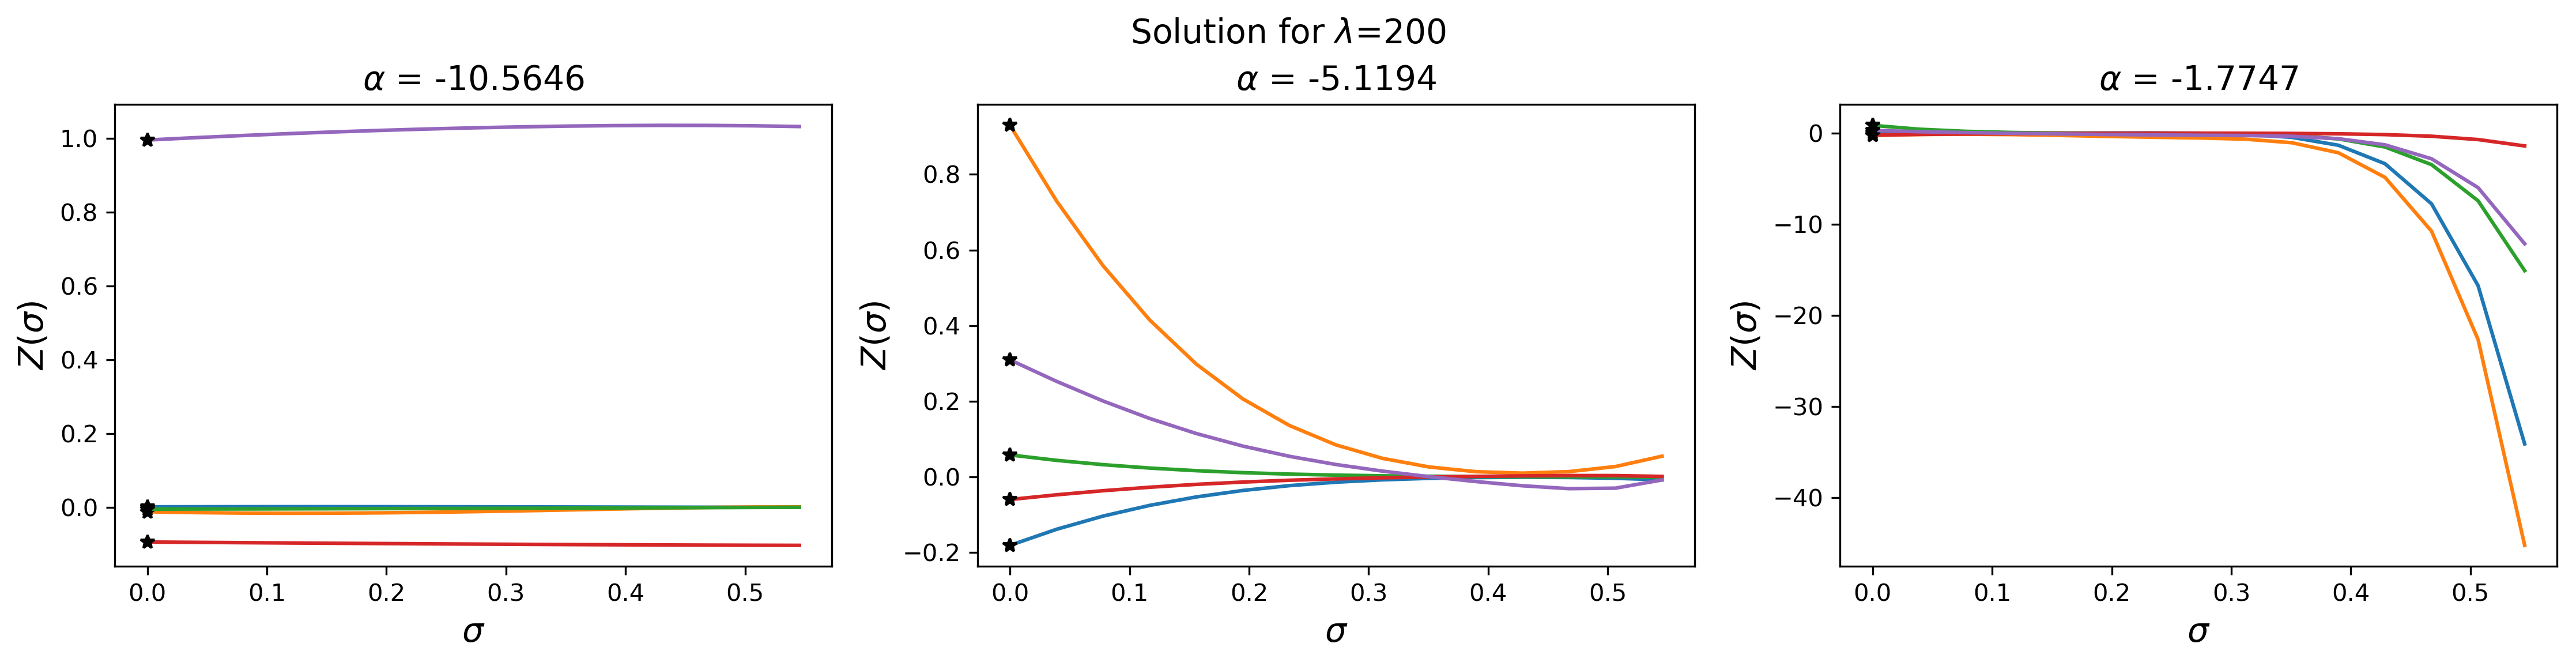

In [22]:
for p in [0,1,2]:
    A, ux, e_val, e_vec, alpha_m = solve_evans(10, pos=p)
    #print(e_val, e_vec)
    fsig = e_val + sigma*(alpha_m - e_val)/sm

    my_sys = SystemSolve(5,10,A,ux,fsig,e_vec, False)
    my_sys.createSys()

    sigs = np.linspace(sp,sm,15)
    W = np.zeros((5,len(sigs)))
    for i,sig in enumerate(sigs):
        w_val = my_sys.evalW(sig)
        W[:,i] = w_val
    plt.subplot(1,3,p+1)
    plt.xlabel(r'$\sigma$', fontsize=14)
    plt.ylabel(r'$Z(\sigma)$', fontsize=14)
    for i in range(len(W[:,0])):
        plt.plot(sigs[:], -W[i][:],label=i+1)
        plt.plot(0,-e_vec[i],'*k')
    #plt.legend()
    #plt.suptitle("With f'($\sigma$)")
    plt.title(r"$\alpha$ = {}".format(round(e_val,4)), fontsize=14)
    
    
    print(my_sys.checkBNorms())

plt.tight_layout()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(r'Solution for $\lambda$=200', fontsize=14)
plt.savefig('lam200sol.png')
plt.show()



power = 0


10.564589700204*B0_1 + 1.0*B0_2


45.4545454545455*B0_1 + 15.1100442456585*B0_2 + 24.7933884297521*B0_4 + 2.47933884297521*B0_5


10.564589700204*B0_3 + 10.0*B0_4 + 1.0*B0_5


10.564589700204*B0_4 + 1.0*B0_5


1.66666666666667*B0_2 + 4.54545454545454*B0_3 + 4.54545454545454*B0_4 + 0.473680609294894*B0_5


power = 1


11.4205293151334*B1_1 + 1.0*B1_2


100.0*B0_1 + 10.0*B0_2 - 4.62326723772085*B0_3 + 17.6503052402029*B0_4 + 2.62939283444398*B0_5 + 45.4545454545455*B1_1 + 15.9659838605879*B1_2 + 24.7933884297521*B1_4 + 2.47933884297521*B1_5


11.4205293151334*B1_3 + 10.0*B1_4 + 1.0*B1_5


11.4205293151334*B1_4 + 1.0*B1_5


8.57343397511769*B0_3 + 10*B0_4 + 2*B0_5 + 1.66666666666667*B1_2 + 4.54545454545454*B1_3 + 4.54545454545454*B1_4 + 1.32962022422428*B1_5


power = 2


-1.22531505711011*B1_1 + 12.2764689300628*B2_1 + B2_2


0.156604841111204*B0_3 - 112.253150571101*B0_4 - 14.8734247144495*B0_5 + 100.0*B1_1 + 8.77468494288989*B1_2 - 4.62326723772085*B1_3 + 17.6503052402029

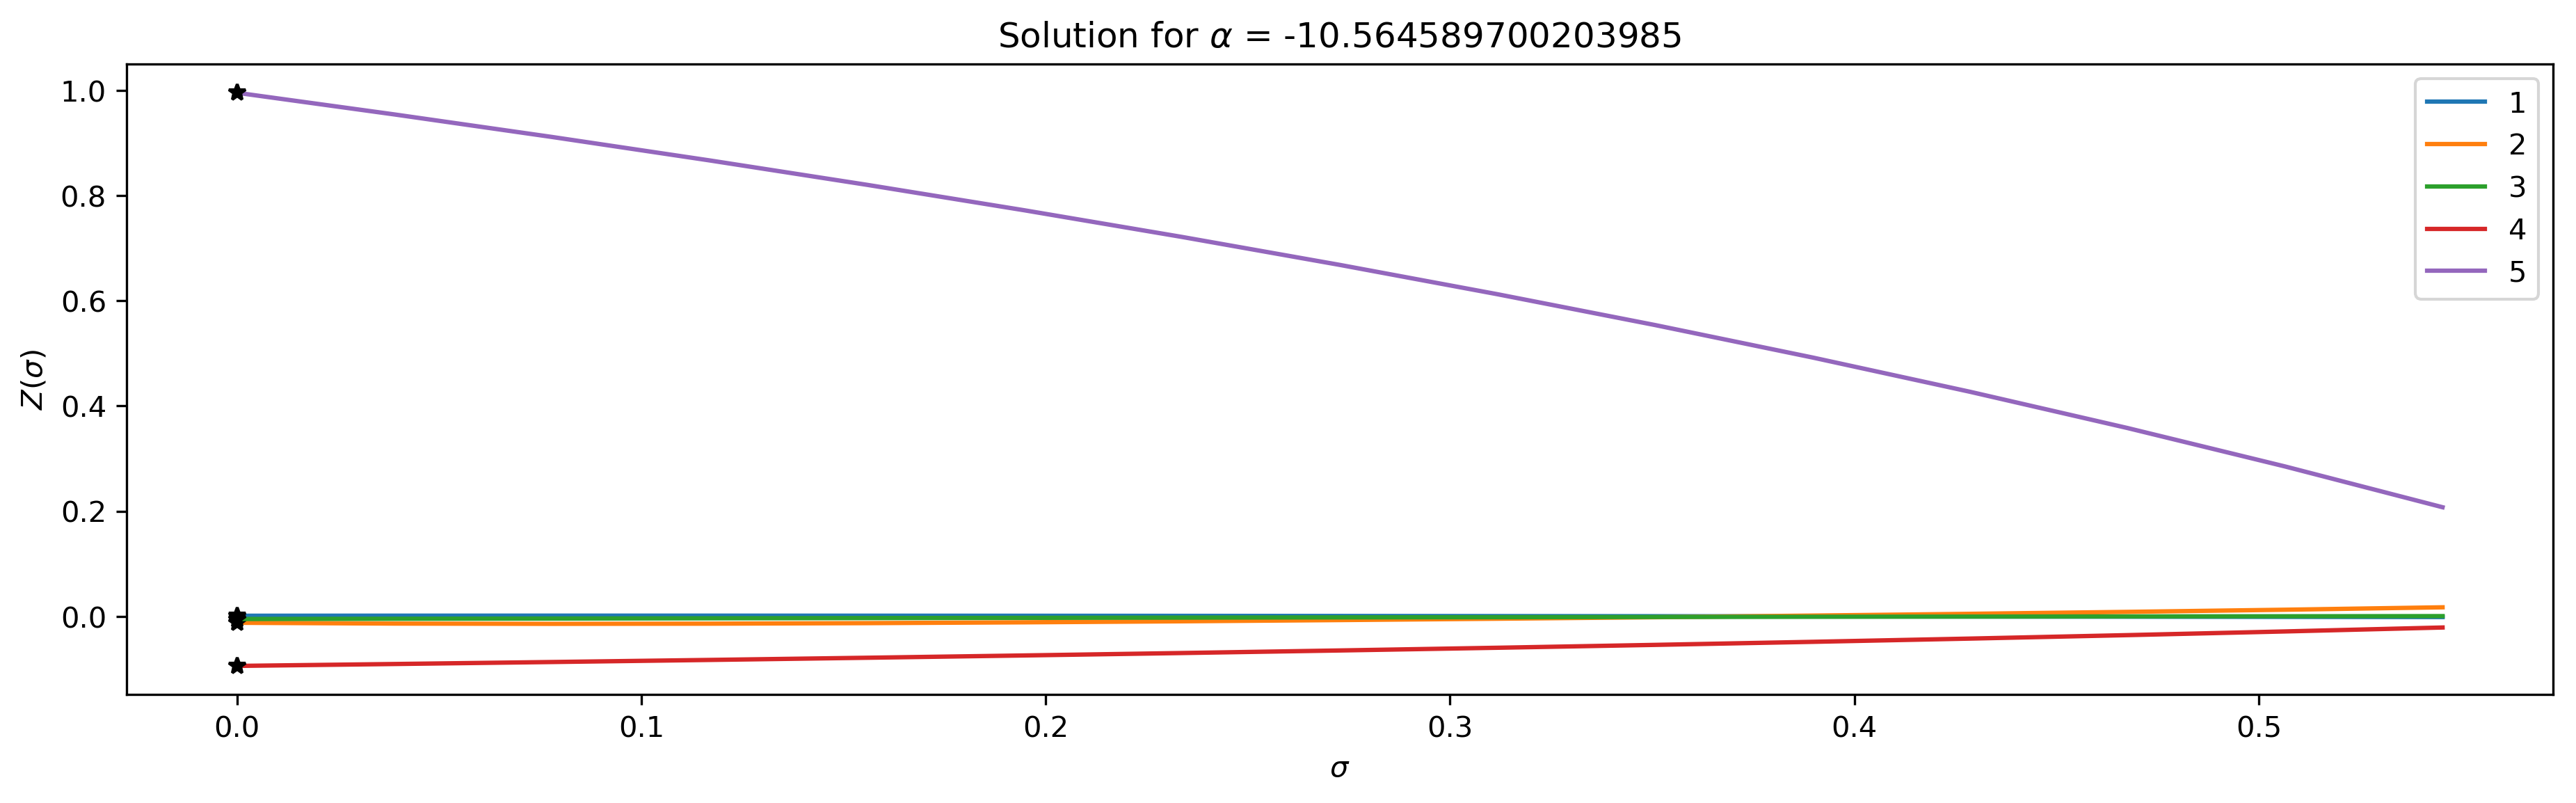

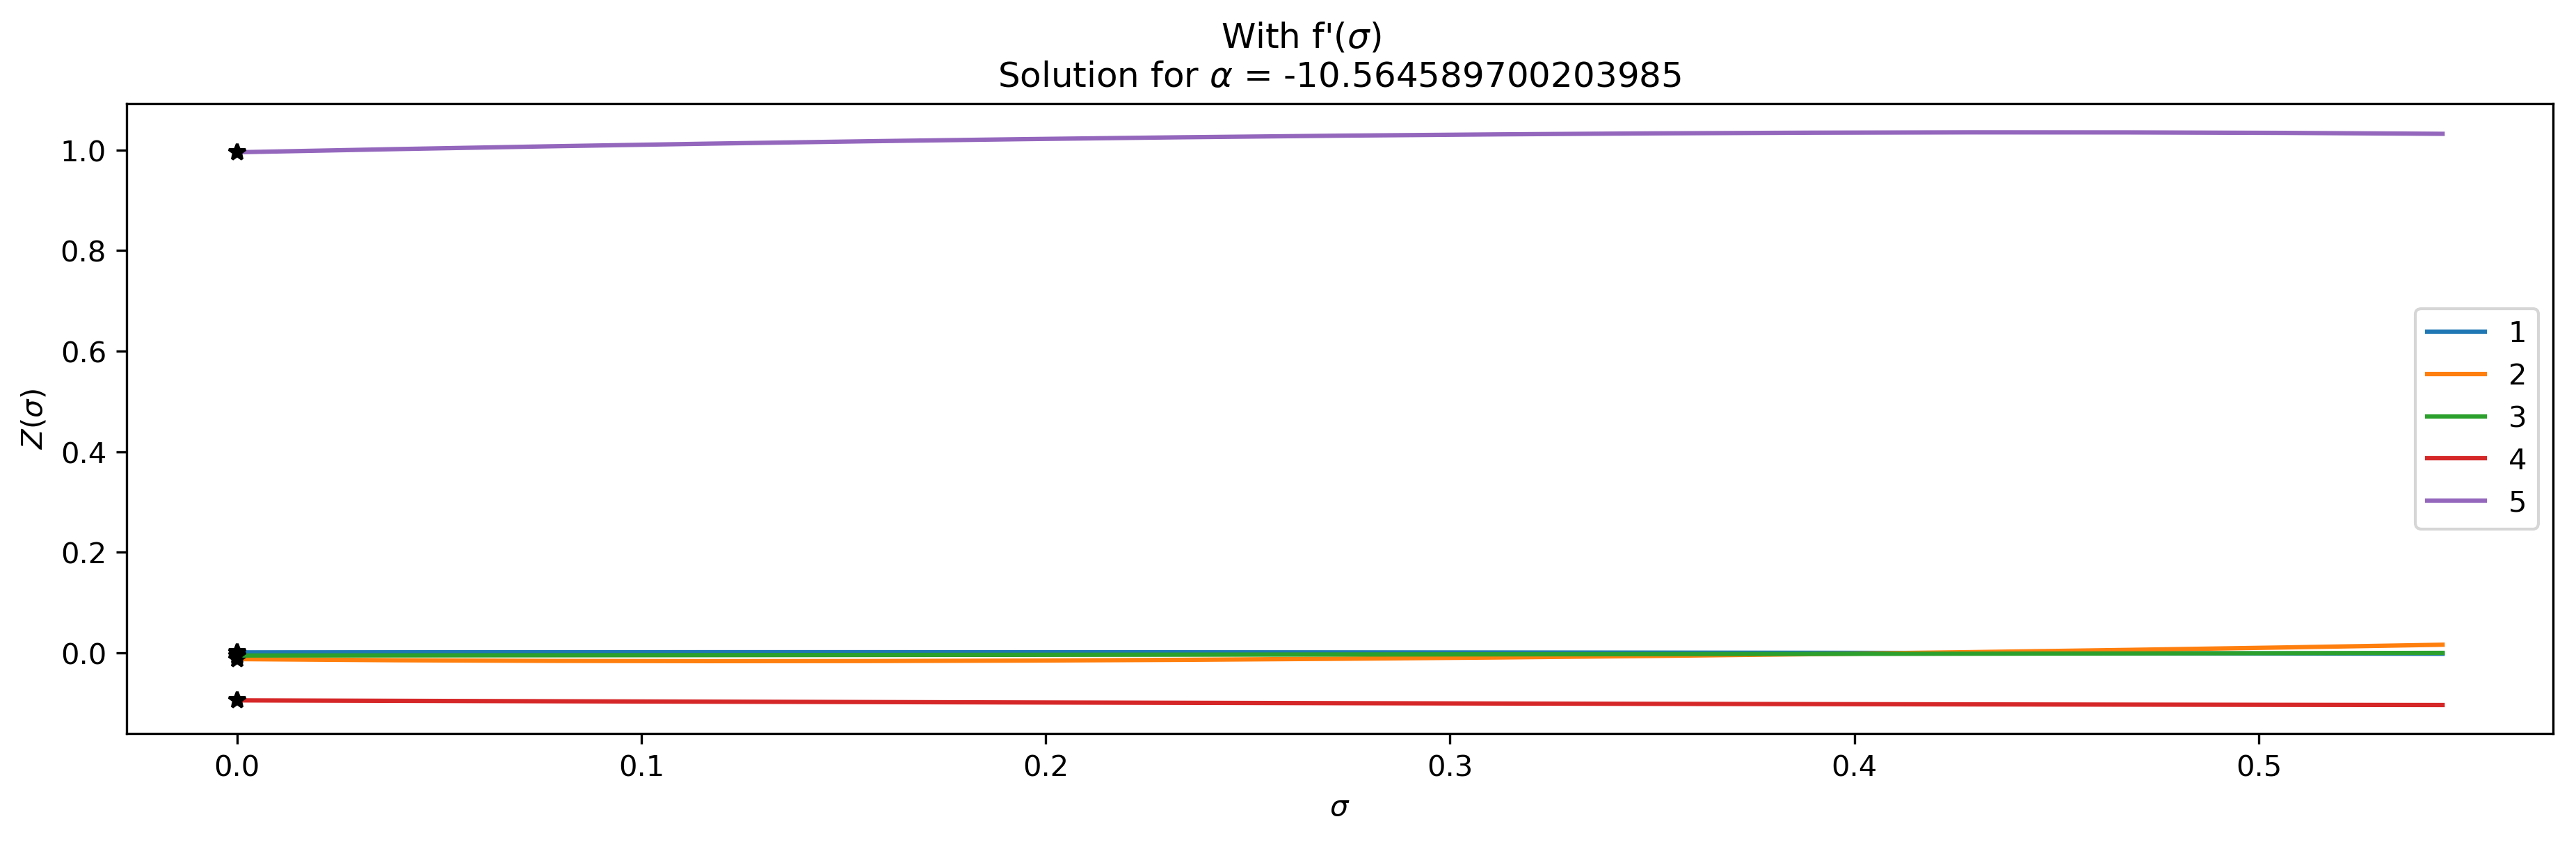

In [9]:
A, ux, e_val, e_vec, alpha_m = solve_evans(10, pos=0)
#print(e_val, e_vec)
fsig = e_val + sigma*(alpha_m - e_val)/sm
my_sys = SystemSolve(5,5,A,ux,e_val,e_vec, True)
my_sys.createSys()

sigs = np.linspace(sp,sm,15)
W = np.zeros((5,len(sigs)))
for i,sig in enumerate(sigs):
    w_val = my_sys.evalW(sig)
    W[:,i] = w_val

for i in range(len(W[:,0])):
    plt.plot(sigs[:], -W[i][:],label=i+1)
    plt.plot(0,-e_vec[i],'*k')
plt.legend()
plt.title(r'Solution for $\alpha$ = {}'.format(e_val))
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$Z(\sigma)$')
plt.show()

my_sys = SystemSolve(5,5,A,ux,fsig,e_vec, False)
my_sys.createSys()

sigs = np.linspace(sp,sm,15)
W = np.zeros((5,len(sigs)))
for i,sig in enumerate(sigs):
    w_val = my_sys.evalW(sig)
    W[:,i] = w_val

for i in range(len(W[:,0])):
    plt.plot(sigs[:], -W[i][:],label=i+1)
    plt.plot(0,-e_vec[i],'*k')
plt.legend()
plt.suptitle("With f'($\sigma$)")
plt.title(r"Solution for $\alpha$ = {}".format(e_val))
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$Z(\sigma)$')
plt.show()

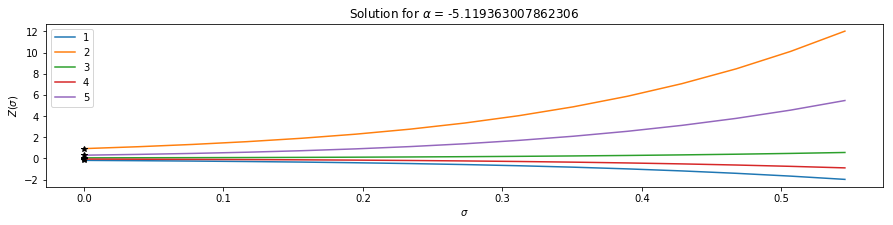

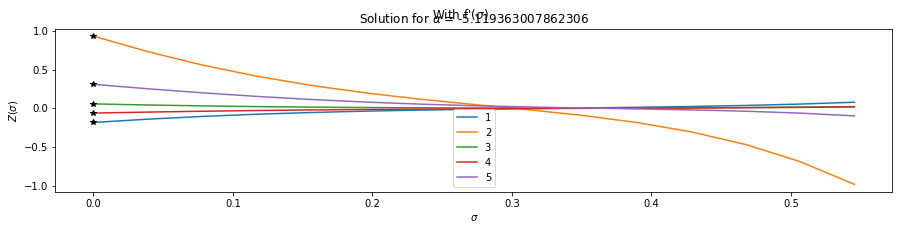

In [9]:
A, ux, e_val, e_vec, alpha_m = solve_evans(10, pos=1)
#print(e_val, e_vec)
fsig = e_val + sigma*(alpha_m - e_val)/sm
my_sys = SystemSolve(5,5,A,ux,e_val,e_vec, False)
my_sys.createSys()

sigs = np.linspace(sp,sm,15)
W = np.zeros((5,len(sigs)))
for i,sig in enumerate(sigs):
    w_val = my_sys.evalW(sig)
    W[:,i] = w_val

for i in range(len(W[:,0])):
    plt.plot(sigs[:], -W[i][:],label=i+1)
    plt.plot(0,-e_vec[i],'*k')
plt.legend()
plt.title(r'Solution for $\alpha$ = {}'.format(e_val))
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$Z(\sigma)$')
plt.show()

my_sys = SystemSolve(5,5,A,ux,fsig,e_vec, False)
my_sys.createSys()

sigs = np.linspace(sp,sm,15)
W = np.zeros((5,len(sigs)))
for i,sig in enumerate(sigs):
    w_val = my_sys.evalW(sig)
    W[:,i] = w_val

for i in range(len(W[:,0])):
    plt.plot(sigs[:], -W[i][:],label=i+1)
    plt.plot(0,-e_vec[i],'*k')
plt.legend()
plt.suptitle("With f'($\sigma$)")
plt.title(r"Solution for $\alpha$ = {}".format(e_val))
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$Z(\sigma)$')
plt.show()

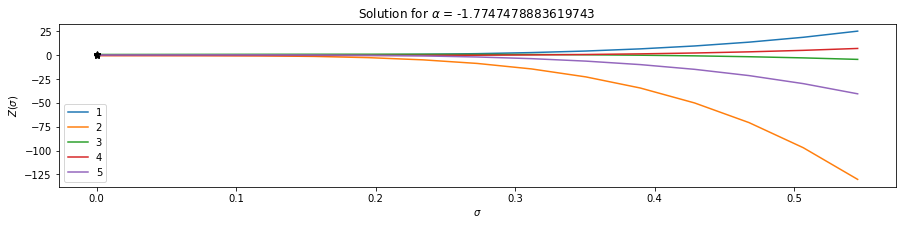

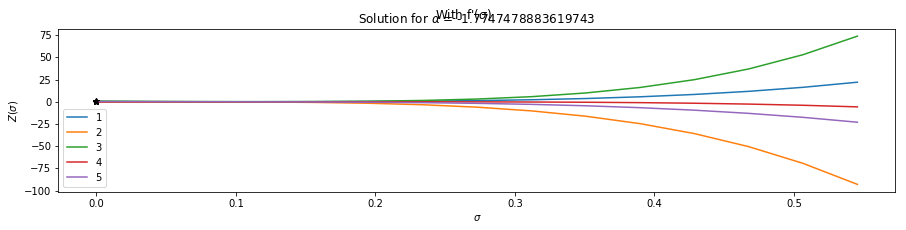

In [10]:
A, ux, e_val, e_vec, alpha_m = solve_evans(10, pos=2)
#print(e_val, e_vec)
fsig = e_val + sigma*(alpha_m - e_val)/sm

my_sys = SystemSolve(5,5,A,ux,e_val,e_vec, False)
my_sys.createSys()

sigs = np.linspace(sp,sm,15)
W = np.zeros((5,len(sigs)))
for i,sig in enumerate(sigs):
    w_val = my_sys.evalW(sig)
    W[:,i] = w_val

for i in range(len(W[:,0])):
    plt.plot(sigs[:], -W[i][:],label=i+1)
    plt.plot(0,-e_vec[i],'*k')
plt.legend()
plt.title(r'Solution for $\alpha$ = {}'.format(e_val))
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$Z(\sigma)$')
plt.show()

my_sys = SystemSolve(5,5,A,ux,fsig,e_vec, False)
my_sys.createSys()

sigs = np.linspace(sp,sm,15)
W = np.zeros((5,len(sigs)))
for i,sig in enumerate(sigs):
    w_val = my_sys.evalW(sig)
    W[:,i] = w_val

for i in range(len(W[:,0])):
    plt.plot(sigs[:], -W[i][:],label=i+1)
    plt.plot(0,-e_vec[i],'*k')
plt.legend()
plt.suptitle("With f'($\sigma$)")
plt.title(r"Solution for $\alpha$ = {}".format(e_val))
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$Z(\sigma)$')
plt.show()

# Test for lambda bound 

In [11]:
def run(lval=10, numterms=5, G_val=5/3, nu_val=.1):
    A, ux, e_val, e_vec, alpha_m = solve_evans(lval, G_val, nu_val, pos=0)
    #print(e_val, e_vec)
    fsig = e_val + sigma*(alpha_m - e_val)/sm

    my_sys = SystemSolve(5,numterms,A,ux,fsig,e_vec, False)
    my_sys.createSys()

    sigs = np.linspace(sp,sm,15)
    W = np.zeros((5,len(sigs)))
    for i,sig in enumerate(sigs):
        w_val = my_sys.evalW(sig)
        #print(w_val)
        W[:,i] = w_val

    plt.subplot(1,3,1)
    for i in range(len(W[:,0])):
        plt.plot(sigs[:], -W[i][:],label=i+1)
        plt.plot(0,-e_vec[i],'*k')
    plt.legend()
    #plt.suptitle("With f'($\sigma$)")
    plt.title(r"Solution for $\alpha$ = {}".format(e_val))
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'$Z(\sigma)$')
    #plt.show()

    #print('--'*50)

    A, ux, e_val, e_vec, alpha_m = solve_evans(lval, G_val, nu_val, pos=1)
    #print(e_val, e_vec)
    fsig = e_val + sigma*(alpha_m - e_val)/sm

    my_sys = SystemSolve(5,numterms,A,ux,fsig,e_vec, False)
    my_sys.createSys()

    sigs = np.linspace(sp,sm,15)
    W = np.zeros((5,len(sigs)))
    for i,sig in enumerate(sigs):
        w_val = my_sys.evalW(sig)
        W[:,i] = w_val

    plt.subplot(1,3,2)
    for i in range(len(W[:,0])):
        plt.plot(sigs[:], -W[i][:],label=i+1)
        plt.plot(0,-e_vec[i],'*k')
    plt.legend()
    #plt.suptitle("With f'($\sigma$)")
    plt.title(r"Solution for $\alpha$ = {}".format(e_val))
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'$Z(\sigma)$')
    #plt.show()

    #print('--'*55)

    A, ux, e_val, e_vec, alpha_m = solve_evans(lval, G_val, nu_val, pos=2)
    #print(e_val, e_vec)
    fsig = e_val + sigma*(alpha_m - e_val)/sm

    my_sys = SystemSolve(5,numterms,A,ux,fsig,e_vec, False)
    my_sys.createSys()

    sigs = np.linspace(sp,sm,15)
    W = np.zeros((5,len(sigs)))
    for i,sig in enumerate(sigs):
        w_val = my_sys.evalW(sig)
        W[:,i] = w_val

    plt.subplot(1,3,3)
    for i in range(len(W[:,0])):
        plt.plot(sigs[:], -W[i][:],label=i+1)
        plt.plot(0,-e_vec[i],'*k')
    plt.legend()
    #plt.suptitle("With f'($\sigma$)")
    plt.title(r"Solution for $\alpha$ = {}".format(e_val))
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'$Z(\sigma)$')
    plt.show()

Gamma: 0.2 	nu: 0.2 	lambda: 7.3653


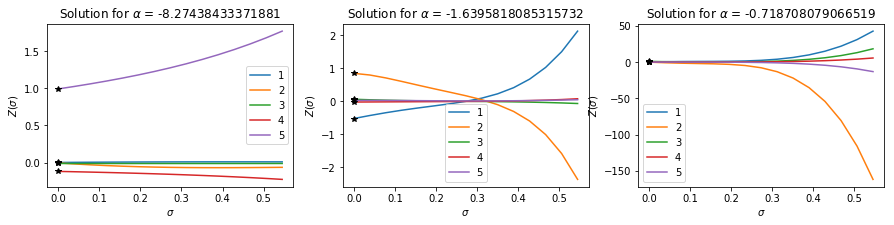

Gamma: 0.2 	nu: 0.5 	lambda: 7.034


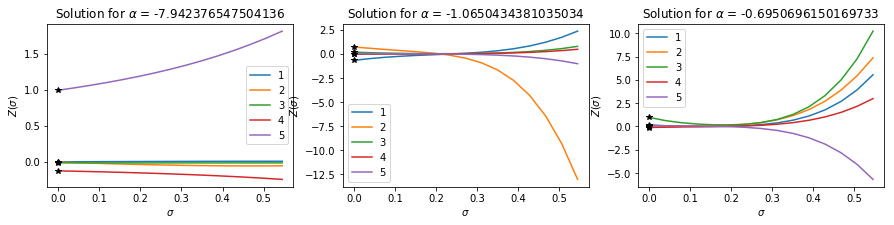

Gamma: 0.2 	nu: 1.0 	lambda: 6.9262


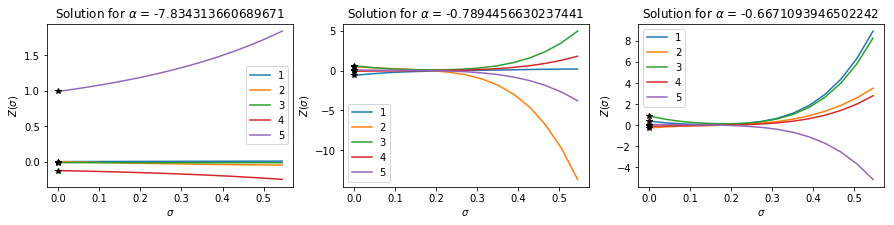

Gamma: 0.2 	nu: 2.0 	lambda: 6.8732


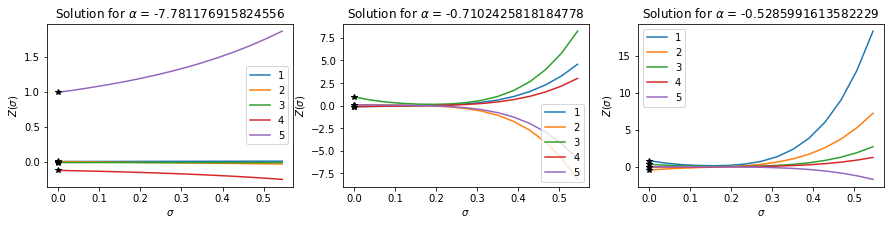

Gamma: 0.2 	nu: 5.0 	lambda: 6.8402


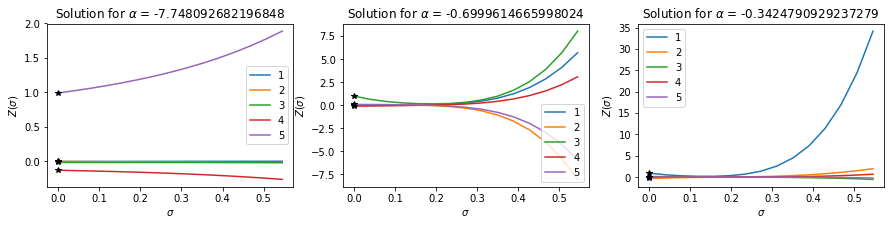

Gamma: 0.4 	nu: 0.2 	lambda: 4.3233


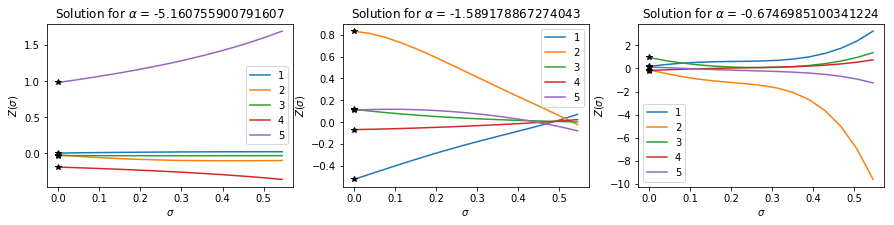

Gamma: 0.4 	nu: 0.5 	lambda: 3.6037


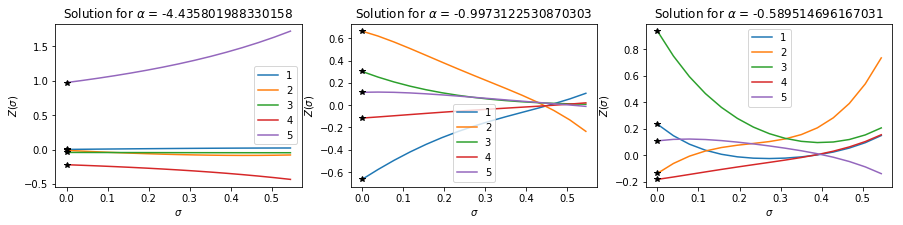

Gamma: 0.4 	nu: 1.0 	lambda: 3.3641


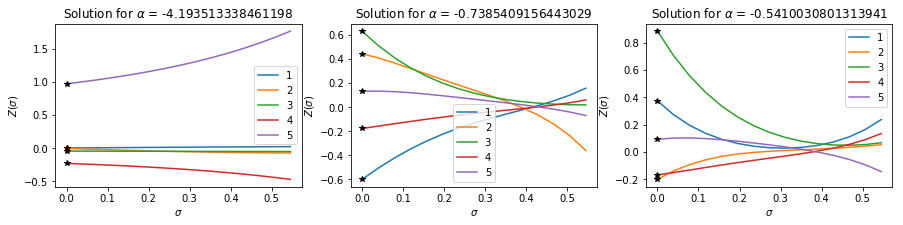

Gamma: 0.4 	nu: 2.0 	lambda: 3.2449


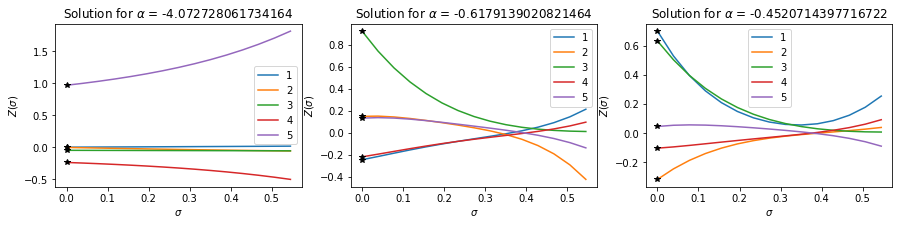

Gamma: 0.4 	nu: 5.0 	lambda: 3.173


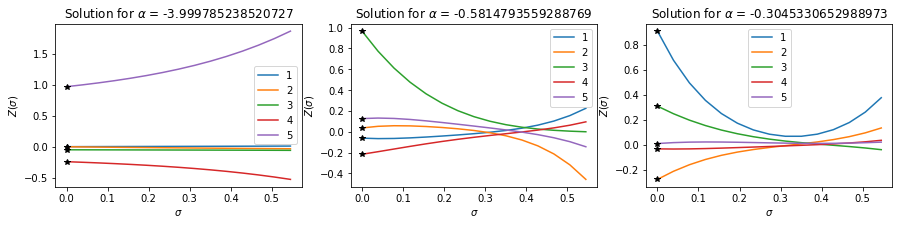

Gamma: 0.6 	nu: 0.2 	lambda: 3.8725


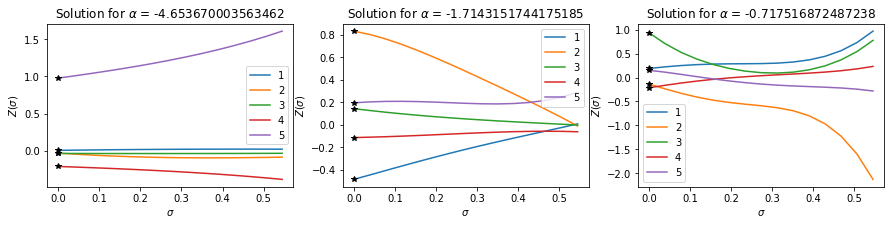

Gamma: 0.6 	nu: 0.5 	lambda: 2.7025


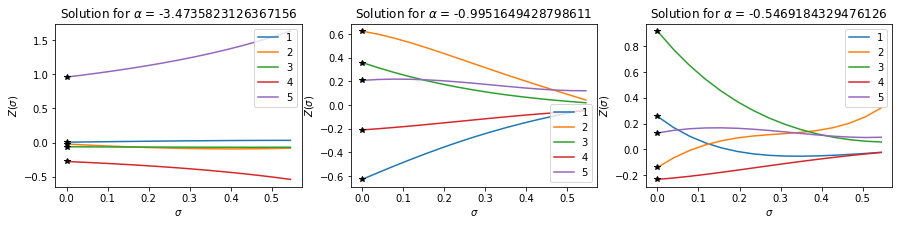

Gamma: 0.6 	nu: 1.0 	lambda: 2.3126


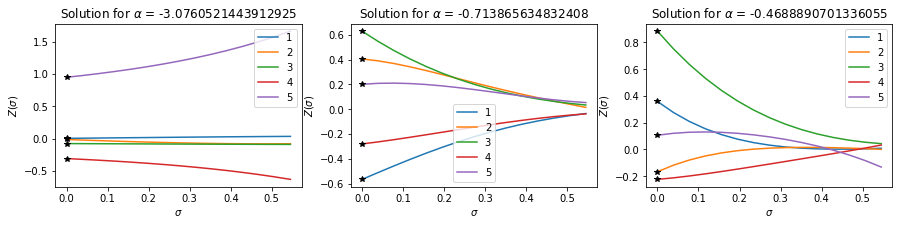

Gamma: 0.6 	nu: 2.0 	lambda: 2.1179


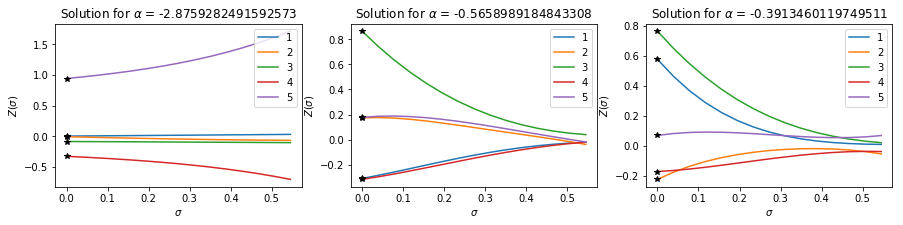

Gamma: 0.6 	nu: 5.0 	lambda: 2.0011


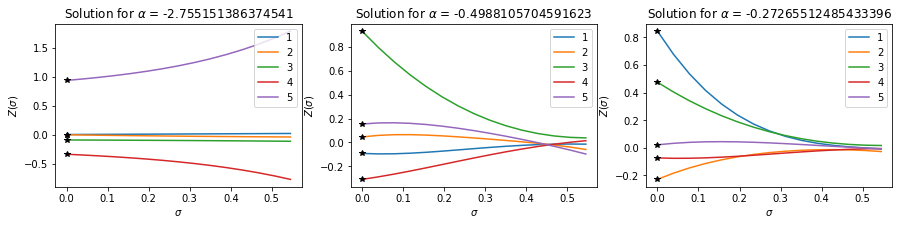

Gamma: 0.6666666666666666 	nu: 0.2 	lambda: 3.9091


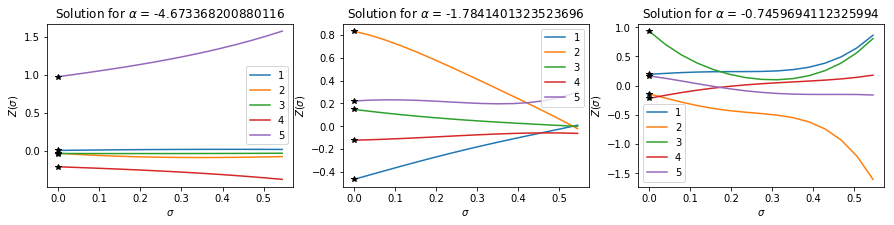

Gamma: 0.6666666666666666 	nu: 0.5 	lambda: 2.5759


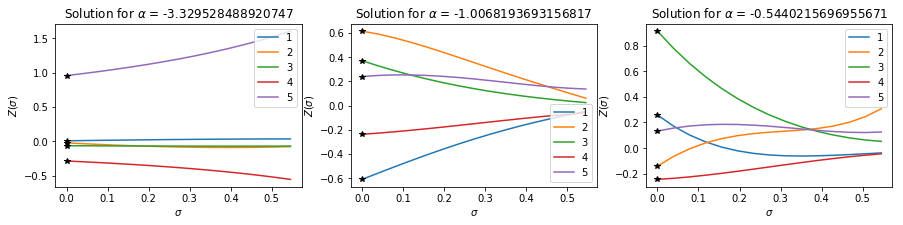

Gamma: 0.6666666666666666 	nu: 1.0 	lambda: 2.1314


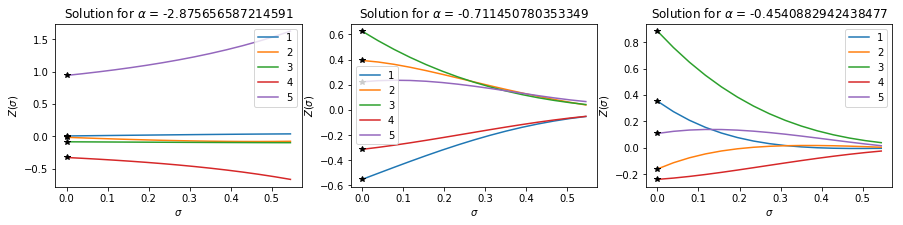

Gamma: 0.6666666666666666 	nu: 2.0 	lambda: 1.9097


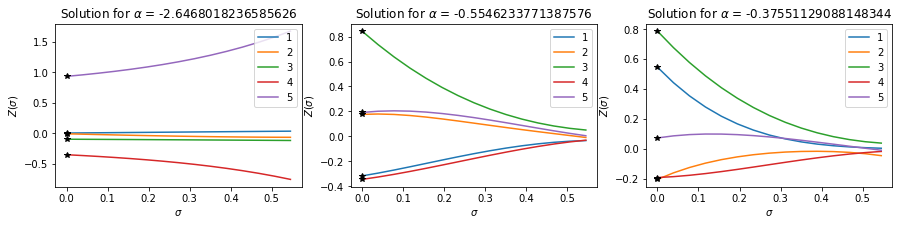

Gamma: 0.6666666666666666 	nu: 5.0 	lambda: 1.7764


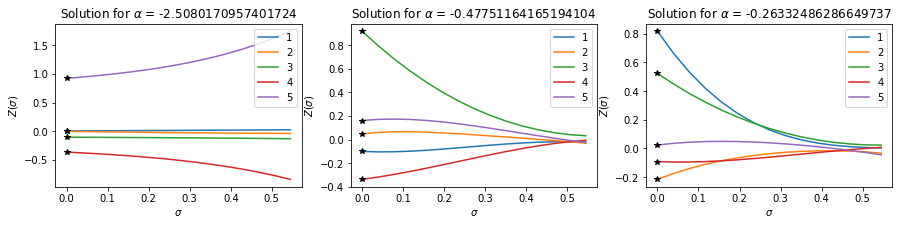

Gamma: 0.8 	nu: 0.2 	lambda: 4.1387


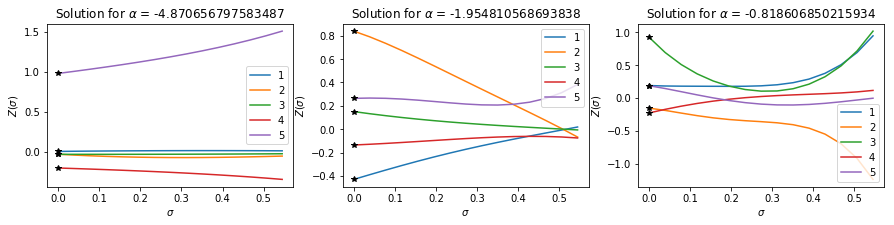

Gamma: 0.8 	nu: 0.5 	lambda: 2.4587


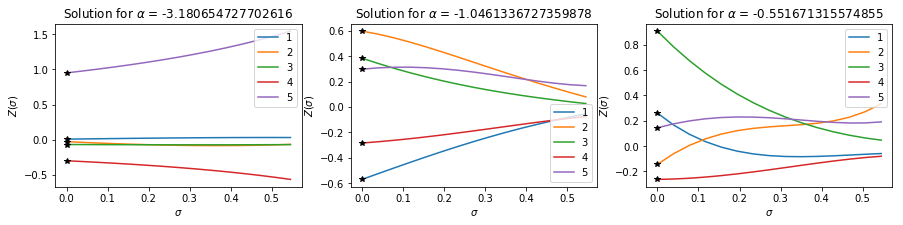

Gamma: 0.8 	nu: 1.0 	lambda: 1.899


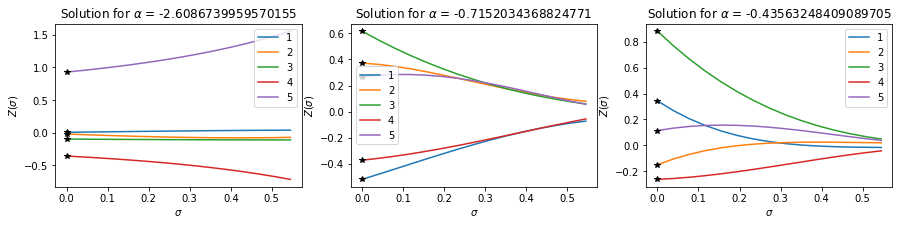

Gamma: 0.8 	nu: 2.0 	lambda: 1.6192


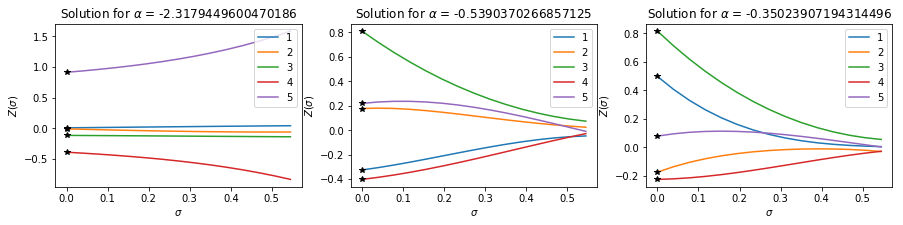

Gamma: 0.8 	nu: 5.0 	lambda: 1.4513


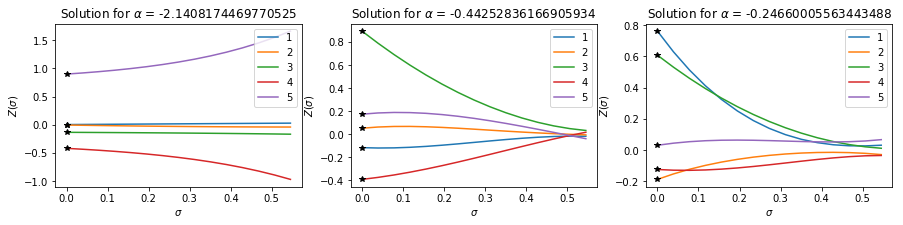

Gamma: 1 	nu: 0.2 	lambda: 4.7494


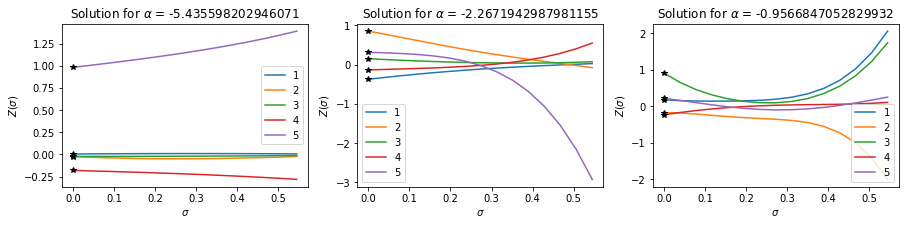

Gamma: 1 	nu: 0.5 	lambda: 2.4994


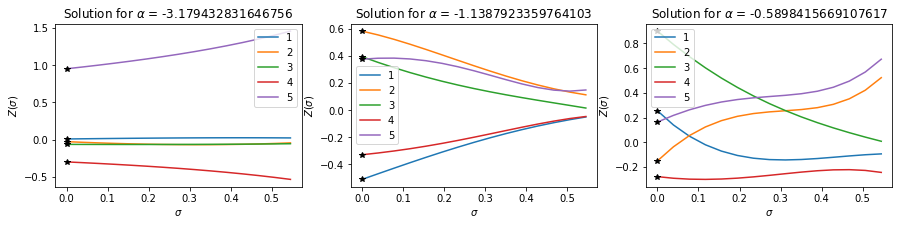

Gamma: 1 	nu: 1.0 	lambda: 1.7497


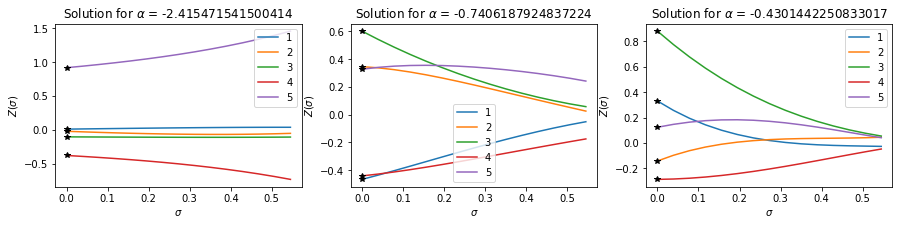

Gamma: 1 	nu: 2.0 	lambda: 1.3748


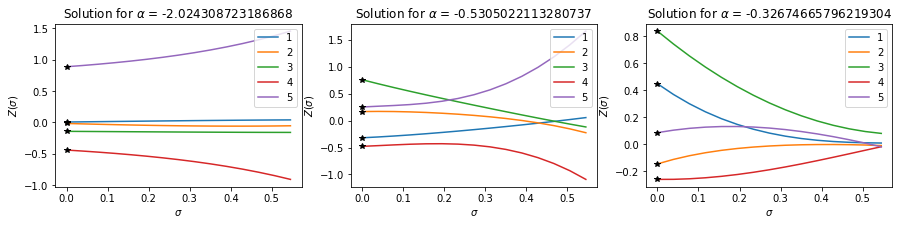

Gamma: 1 	nu: 5.0 	lambda: 1.15


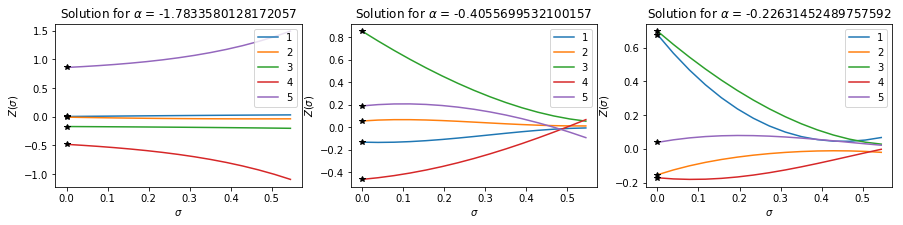

Gamma: 1.2 	nu: 0.2 	lambda: 5.5806


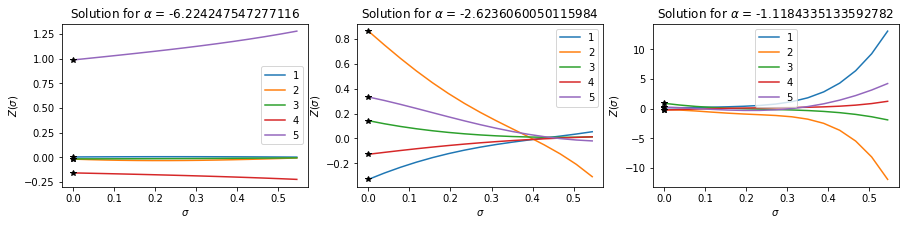

Gamma: 1.2 	nu: 0.5 	lambda: 2.701


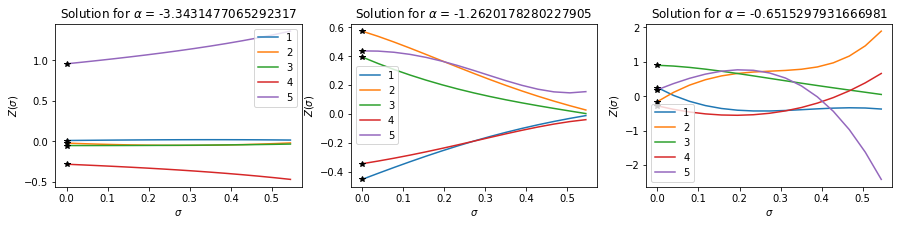

Gamma: 1.2 	nu: 1.0 	lambda: 1.7409


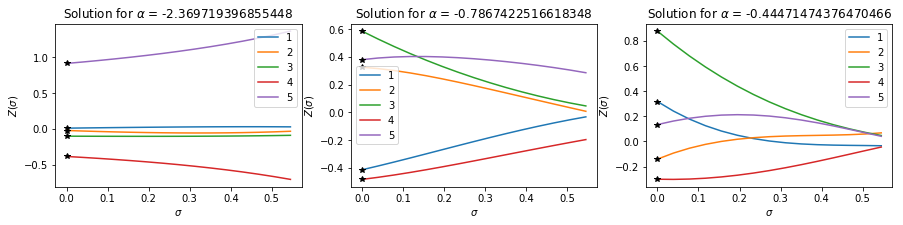

Gamma: 1.2 	nu: 2.0 	lambda: 1.261


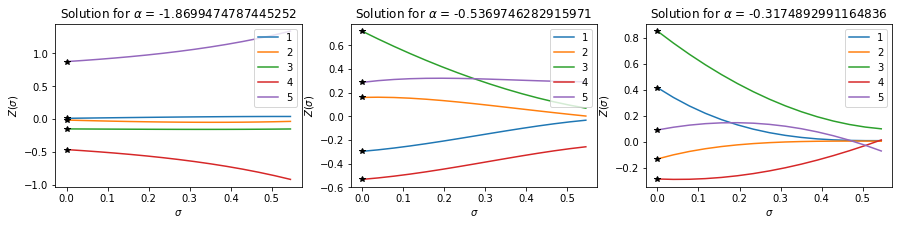

Gamma: 1.2 	nu: 5.0 	lambda: 0.9732


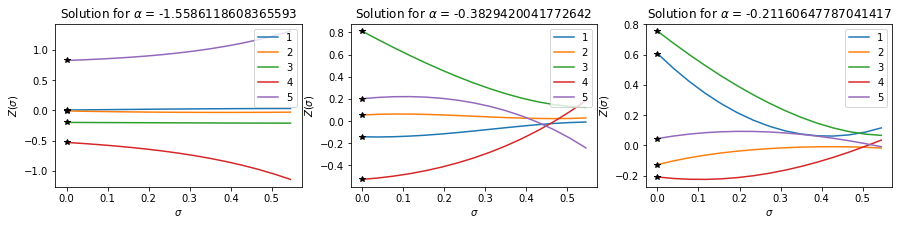

Gamma: 1.4 	nu: 0.2 	lambda: 6.5796


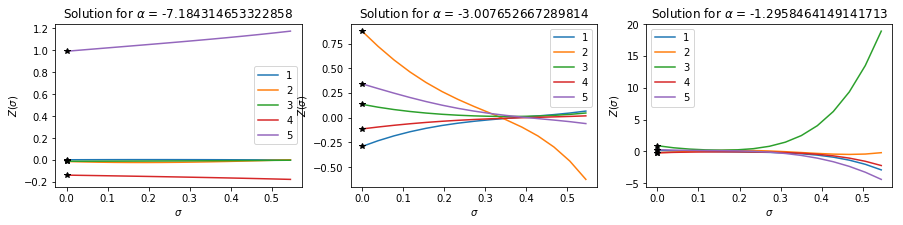

Gamma: 1.4 	nu: 0.5 	lambda: 3.01


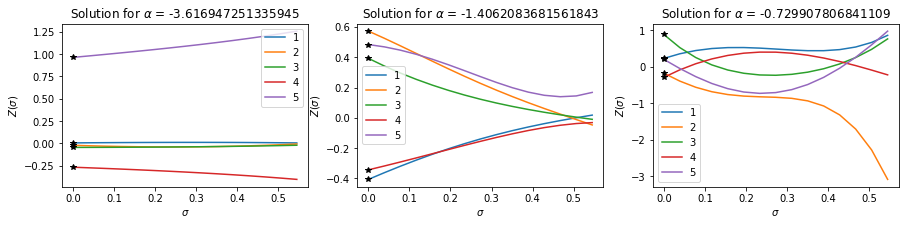

Gamma: 1.4 	nu: 1.0 	lambda: 1.8201


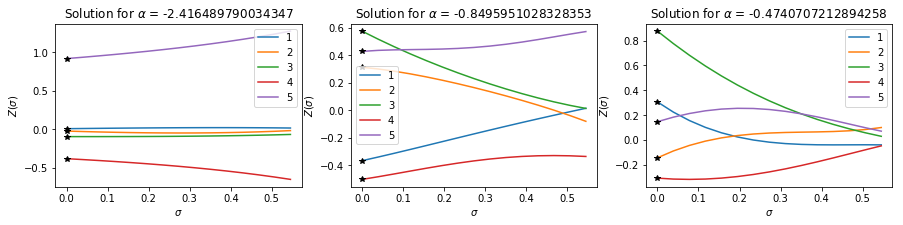

Gamma: 1.4 	nu: 2.0 	lambda: 1.2251


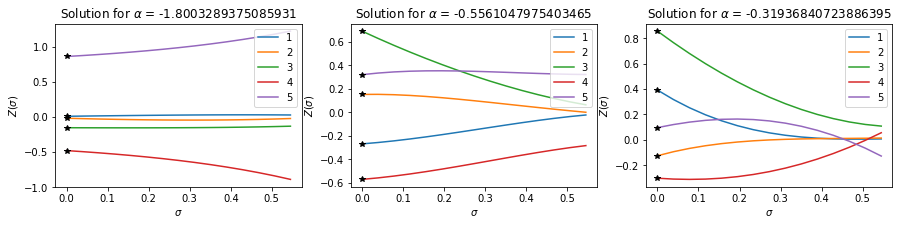

Gamma: 1.4 	nu: 5.0 	lambda: 0.8683


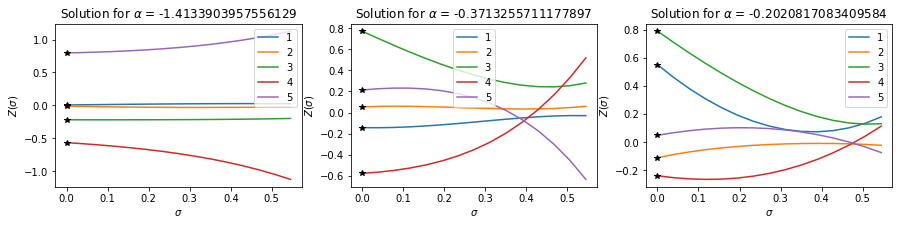

Gamma: 1.6 	nu: 0.2 	lambda: 7.7201


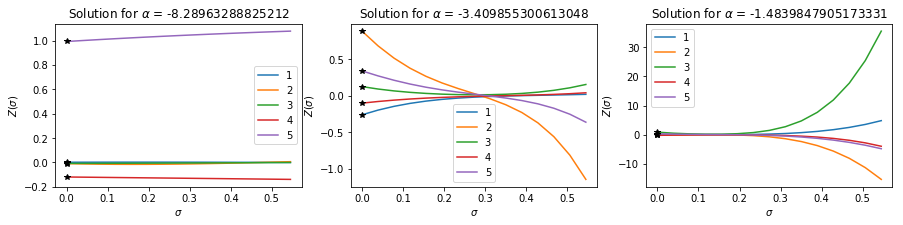

Gamma: 1.6 	nu: 0.5 	lambda: 3.4005


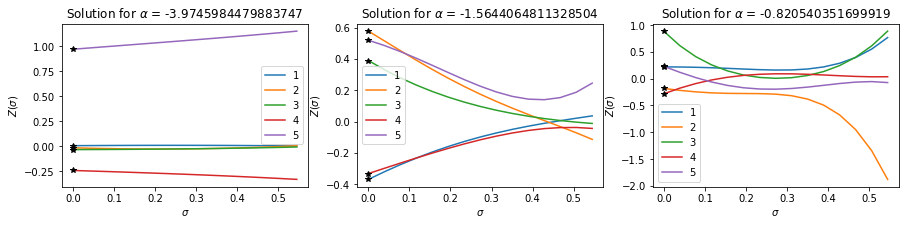

Gamma: 1.6 	nu: 1.0 	lambda: 1.9606


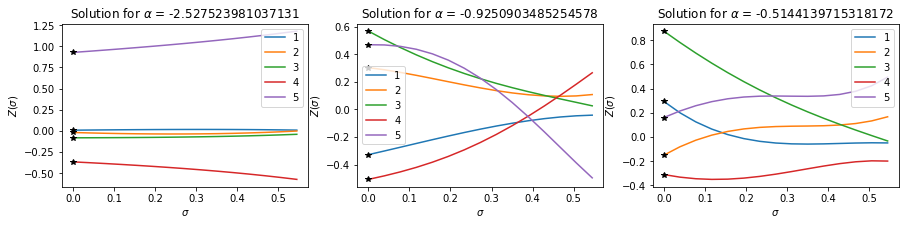

Gamma: 1.6 	nu: 2.0 	lambda: 1.2407


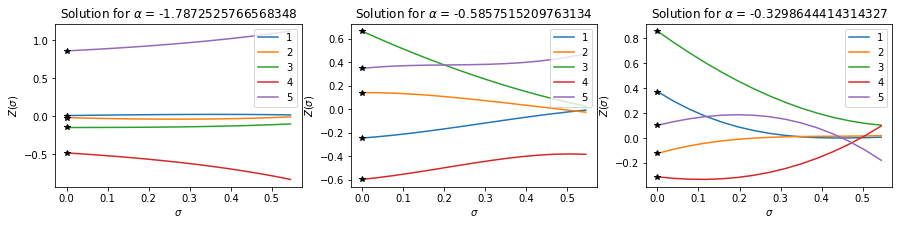

Gamma: 1.6 	nu: 5.0 	lambda: 0.8088


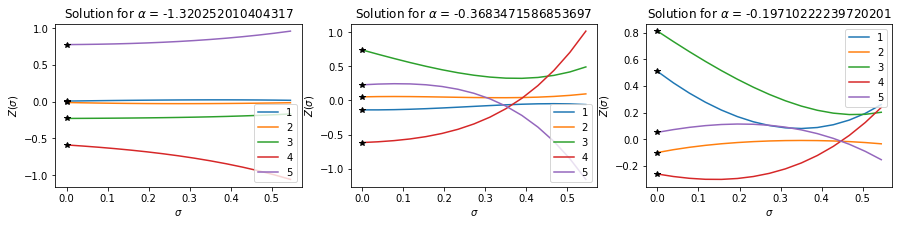

Gamma: 1.8 	nu: 0.2 	lambda: 8.9878


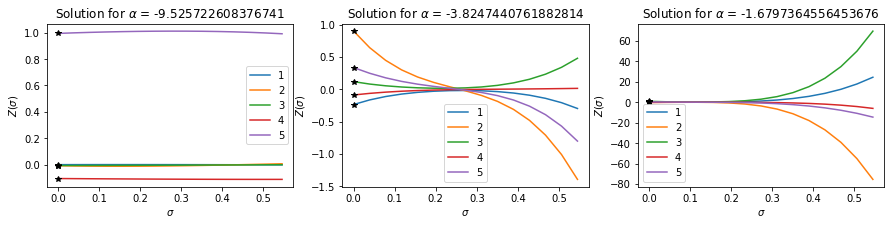

Gamma: 1.8 	nu: 0.5 	lambda: 3.8582


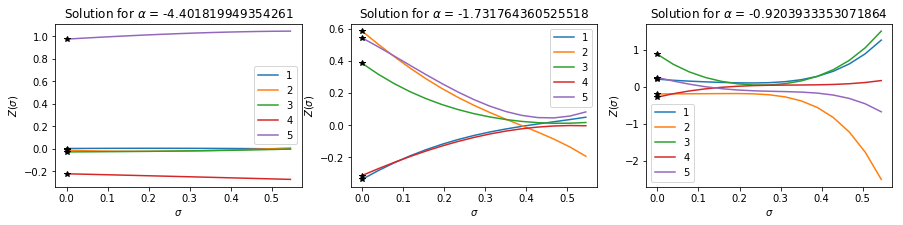

Gamma: 1.8 	nu: 1.0 	lambda: 2.1484


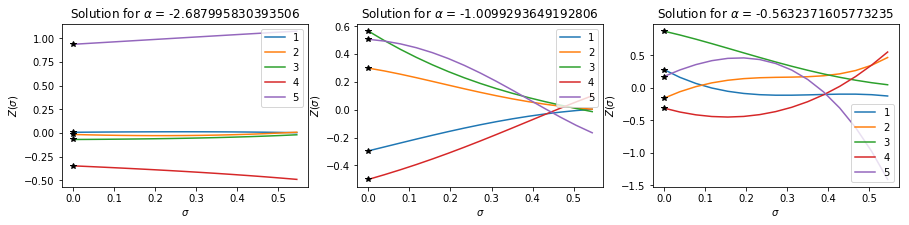

Gamma: 1.8 	nu: 2.0 	lambda: 1.2935


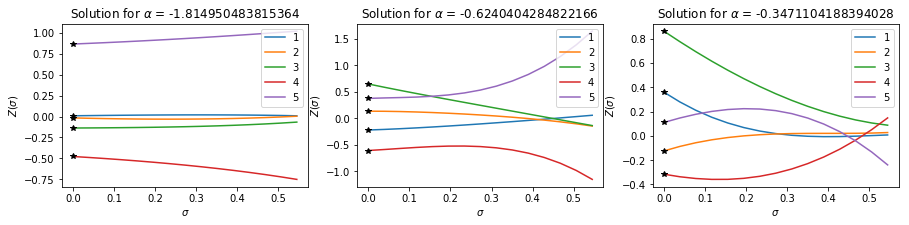

Gamma: 1.8 	nu: 5.0 	lambda: 0.7806


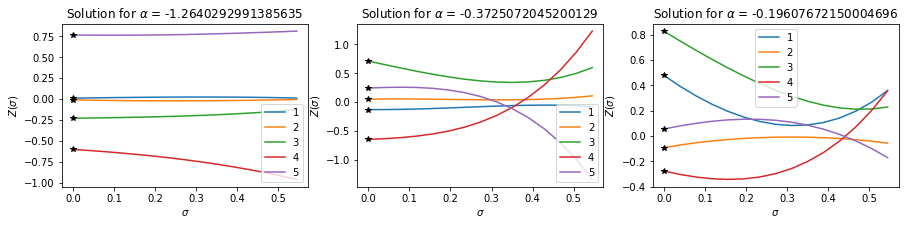

Gamma: 2 	nu: 0.2 	lambda: 10.3741


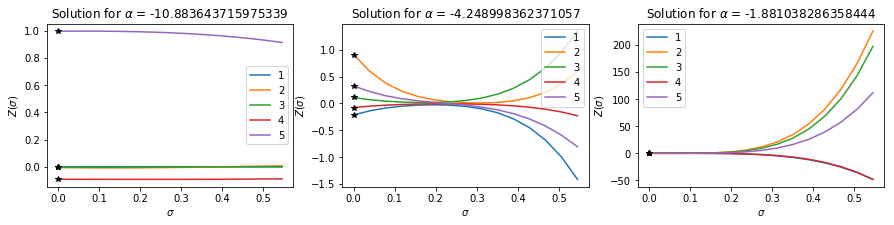

Gamma: 2 	nu: 0.5 	lambda: 4.3746


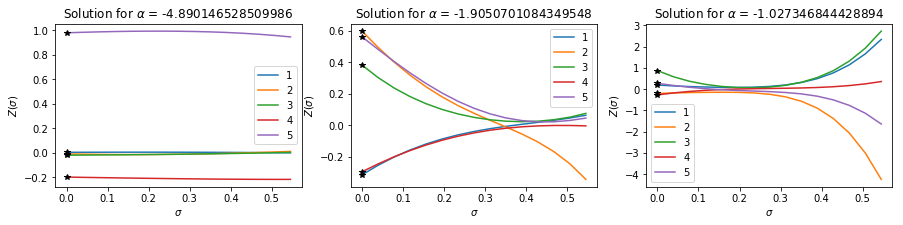

Gamma: 2 	nu: 1.0 	lambda: 2.3748


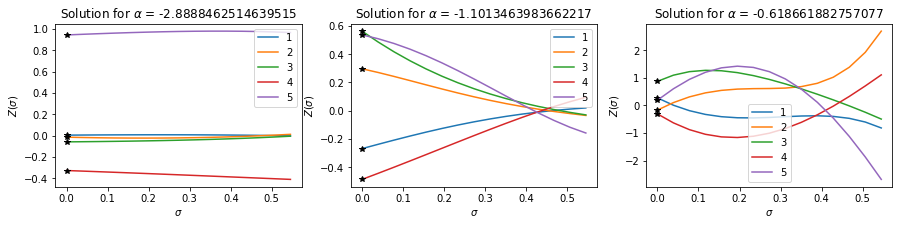

Gamma: 2 	nu: 2.0 	lambda: 1.3749


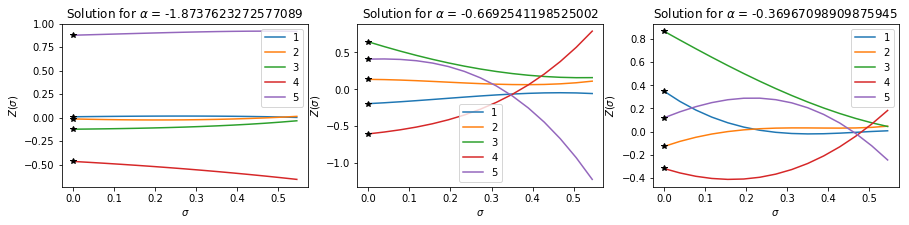

Gamma: 2 	nu: 5.0 	lambda: 0.775


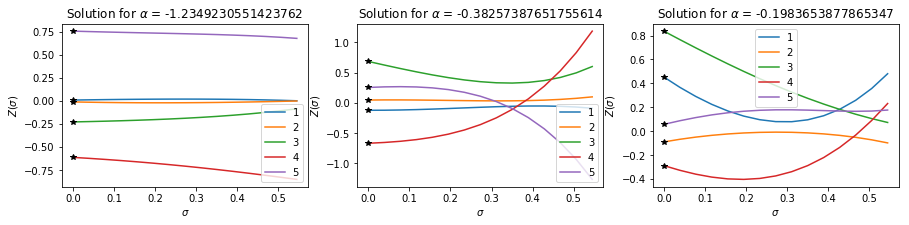

In [12]:
G_vals = [.2,.4,.6,2/3,.8,1,1.2,1.4,1.6,1.8,2];
nu_vals = [0.2, 0.5, 1.0, 2.0, 5.0];

vals = np.array([[7.3653,    7.0340,    6.9262,    6.8732,    6.8402],
                [4.3233,    3.6037,    3.3641,    3.2449,    3.1730],
                [3.8725,    2.7025,    2.3126,    2.1179,    2.0011],
                [3.9091,    2.5759,    2.1314,    1.9097,    1.7764],
                [4.1387,    2.4587,    1.8990,    1.6192,    1.4513],
                [4.7494,    2.4994,    1.7497,    1.3748,    1.1500],
                [5.5806,    2.7010,    1.7409,    1.2610,    0.9732],
                [6.5796,    3.0100,    1.8201,    1.2251,    0.8683],
                [7.7201,    3.4005,    1.9606,    1.2407,    0.8088],
                [8.9878,    3.8582,    2.1484,    1.2935,    0.7806],
                [10.3741,   4.3746,    2.3748,    1.3749,    0.7750]])

for i,di in enumerate(G_vals):
    for j,dj in enumerate(nu_vals):
        print('Gamma:',di,'\tnu:',dj, '\tlambda:',vals[i,j])
        try:
            run(lval=vals[i,j],G_val=di,nu_val=dj)
        except:
            print('did not work')

### Test various real values for $\lambda$

Gamma: 0.6666666666666666 	nu: 1.0 	lambda: 2.1314
5 terms


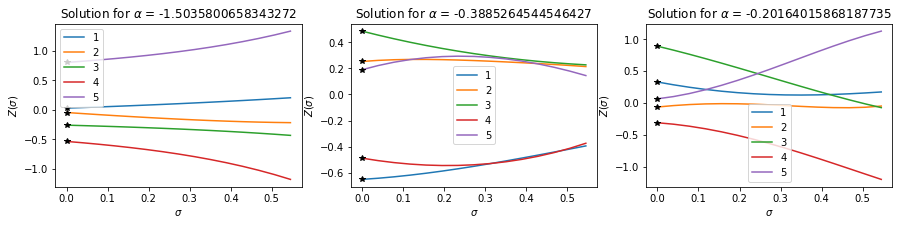

10 terms


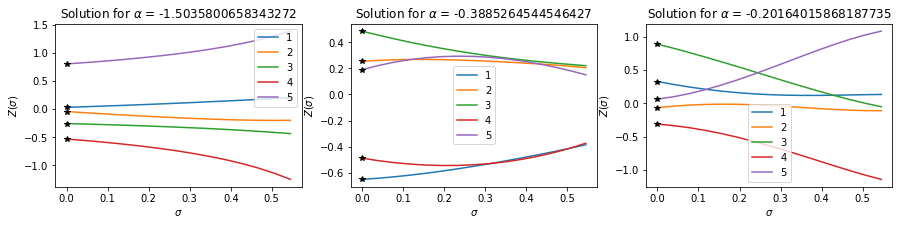

20 terms


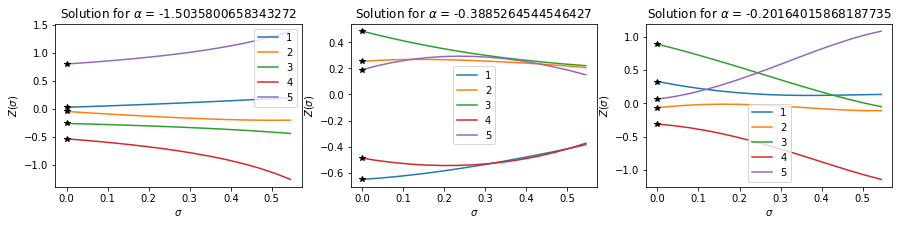

In [14]:
numtermsL = [5,10,20]
di = G_vals[3]
dj = nu_vals[2]
lval = vals[3,2]
print('Gamma:',di,'\tnu:',dj, '\tlambda:',lval)
        
for n in numtermsL:
    try:
        print(n, 'terms')
        run(lval=vals[i,j],G_val=di,nu_val=dj, numterms=n)
    except:
        print('did not work')

In [ ]:
def run_sep(which, lval=10, numterms=5, both=False, Gval=5/3, nu_val=1):
    A, ux, e_val, e_vec, alpha_m = solve_evans(lval, Gval, nu_val, pos=which-1, both=both)
    fsig = e_val + sigma*(alpha_m - e_val)/sm

    my_sys = SystemSolve(5,numterms,A,ux,fsig,e_vec, False)
    my_sys.createSys()

    return np.array(my_sys.evalW(sm),dtype=float)

In [ ]:
terms = [10,20,50]
spots = [1,2,3]
for s in spots:
    print('------------------------')
    if s == 1:
        see = 'Most Negative:'
    elif s == 2:
        see = 'Second Most Negative:'
    else:
        see = 'Third Most Negative:'
    print(see)
    print('------------------------')
    for lval in spots:
        display(Markdown('# $\lambda$ = {}'.format(vals[lval,lval])))
        display(Markdown('# $\Gamma$ = {}'.format(G_vals[lval])))
        display(Markdown('# $\nu$ = {}'.format(nu_vals[lval])))
        for t in terms:
            print('\t{} terms'.format(t))
            run_sep(s, lval, t, Gval=Gvals[lval],nu_val=nu_vals[lval])

In [29]:
terms = range(10,31,2)
lams = [10,100,200]
old_res = []

print('------------------------')
see = 'Third Most Negative:'
print(see)
print('------------------------')
for lval in lams:
    display(Markdown('# $\lambda$ = {}'.format(lval)))
    for t in terms:
        print('\t{} terms'.format(t))
        res = run_sep(s, lval, t, both=False)
        print(res)
        if len(old_res) == 0:
            old_res = res
        else:
            print(np.linalg.norm(old_res-res)/np.linalg.norm(old_res))
            old_res = res

------------------------
Third Most Negative:
------------------------


# $\lambda$ = 10

	10 terms
[34.11931782 45.26468116 15.07514861  1.36985502 12.1211859 ]
	12 terms
[10.39014285 78.40447157  6.60911129 -4.43306196 53.51215189]
0.9846697005746726
	14 terms
[ 1.18317911 61.76928673  2.80123958 -5.5012042  58.26397902]
0.2086440445220148
	16 terms
[-1.44128563 41.82962171  1.13443818 -4.43966039 45.84294076]
0.2785907427032323
	18 terms
[-1.59983073 26.15108496  0.43657703 -2.7685539  28.48157271]
0.3769583746928914
	20 terms
[-1.15780554 15.53647824  0.16098159 -1.31627379 13.60166285]
0.47274669704916106
	22 terms
[-0.70948665  8.77256336  0.05690855 -0.32174679  3.44429891]
0.5912206893515988
	24 terms
[-0.39540731  4.72142395  0.01935938  0.27529541 -2.64539336]
0.7767149527292397
	26 terms
[-0.20672754  2.43317758  0.00638064  0.6036173  -5.9895646 ]
0.7490223218699323
	28 terms
[-1.03097300e-01  1.20704385e+00  2.06728126e-03  7.73198067e-01
 -7.71370713e+00]
0.32710613532371
	30 terms
[-4.96083061e-02  5.79933859e-01  6.86457879e-04  8.56908196e-01
 -8.56290558e+

# $\lambda$ = 100

	10 terms
[ 1.11994471e+11 -6.86532078e+11  2.67937547e+12 -1.75156543e+11
  1.06567005e+12]
344497418998.4093
	12 terms
[ 9.53612083e+12 -5.76027146e+13  2.28913321e+14 -1.47527666e+13
  8.83314451e+13]
84.02606399145904
	14 terms
[ 5.54766099e+14 -3.29761516e+15  1.33822882e+16 -8.49604520e+14
  5.00077867e+15]
57.17157177383589
	16 terms
[ 2.32301059e+16 -1.35668531e+17  5.64083408e+17 -3.52506438e+16
  2.03730402e+17]
40.93747489834824
	18 terms
[ 7.27708633e+17 -4.16798050e+18  1.78229763e+19 -1.09539863e+18
  6.20823466e+18]
30.43155763850146
	20 terms
[ 1.75691608e+19 -9.84718781e+19  4.35003370e+20 -2.62700149e+19
  1.45796319e+20]
23.276380997881542
	22 terms
[ 3.34738895e+20 -1.83112987e+21  8.40061091e+21 -4.98009099e+20
  2.70230194e+21]
18.205985865643996
	24 terms
[ 5.13093382e+21 -2.73069554e+22  1.30916334e+23 -7.61090669e+21
  4.03080549e+22]
14.497250443031144
	26 terms
[ 6.42980941e+22 -3.31646960e+23  1.67387358e+24 -9.53261781e+22
  4.91804851e+23]
11.7135056297388

# $\lambda$ = 200

	10 terms
[ 6.39315002e+13 -5.78581774e+14  2.16368847e+15 -1.02515956e+14
  9.25157172e+14]
0.9999999999857249
	12 terms
[ 2.52487137e+16 -2.27154085e+17  8.54319877e+17 -4.02300991e+16
  3.60696498e+17]
392.9942751887661
	14 terms
[ 6.92762701e+18 -6.19454582e+19  2.34406812e+20 -1.09690146e+19
  9.76882494e+19]
272.7786570027343
	16 terms
[ 1.39119415e+21 -1.23612953e+22  4.70854887e+22 -2.18918263e+21
  1.93621817e+22]
199.42524446354997
	18 terms
[ 2.12518159e+23 -1.87597105e+24  7.19655416e+24 -3.32388109e+23
  2.91894193e+24]
151.49610940820222
	20 terms
[ 2.54393458e+25 -2.23042200e+26  8.62156728e+26 -3.95511530e+25
  3.44788768e+26]
118.52770051931279
	22 terms
[ 2.44319335e+27 -2.12706748e+28  8.28933625e+28 -3.77631627e+27
  3.26722180e+28]
94.92376544623235
	24 terms
[ 1.91903445e+29 -1.65857125e+30  6.52024406e+30 -2.94923398e+29
  2.53182619e+30]
77.47343371318136
	26 terms
[ 1.25260870e+31 -1.07454523e+32  4.26322949e+32 -1.91425252e+31
  1.63016511e+32]
64.229383091344

In [34]:
terms = range(10,41,2)
lams = [20,50]


print('------------------------')
see = 'Third Most Negative:'
print(see)
print('------------------------')
for lval in lams:
    old_res = []
    display(Markdown('# $\lambda$ = {}'.format(lval)))
    for t in terms:
        print('\t{} terms'.format(t))
        res = run_sep(s, lval, t, both=False)
        print(res)
        if len(old_res) == 0:
            old_res = res
        else:
            print(np.linalg.norm(old_res-res)/np.linalg.norm(old_res))
            old_res = res

------------------------
Third Most Negative:
------------------------


# $\lambda$ = 20

	10 terms
[  22317.86525938 -128174.73198932   94717.67081687   -7131.60385657
   -6912.09003517]
	12 terms
[  76514.64087545 -407597.61668807  130542.33241192   -3588.70195332
  -41717.35331865]
1.7924166073931393
	14 terms
[ 114712.35204517 -430337.11444907  125672.24854438     625.46574783
  -40431.11241639]
0.1028789426127775
	16 terms
[ 101902.51765343 -172528.95139077   98246.21789752    1239.93807615
  -12701.67581026]
0.5619941745445142
	18 terms
[66023.71857885 54825.330303   67457.73730184   334.20893299
  6744.68062676]
1.042512436449194
	20 terms
[ 33573.67219729 148865.94536663  42404.27074913   -459.2473416
  12678.70939865]
0.9396146269728086
	22 terms
[ 13363.97368139 145997.08169345  24975.12972183   -708.42376402
  10556.08734603]
0.16945820893456637
	24 terms
[  3560.22033095 106212.01314128  13977.16633166   -548.08679958
   5074.9688352 ]
0.2869194702950273
	26 terms
[ -130.09673939 65300.21061324  7502.44572051  -221.03476795
  -930.87818551]
0.3915610393983103
	2

# $\lambda$ = 50

	10 terms
[ 1.38548408e+08 -5.36643173e+08  2.44384567e+09 -2.10814152e+08
  8.08675851e+08]
	12 terms
[ 2.20415906e+09 -8.02441289e+09  4.03326854e+10 -3.34998015e+09
  1.22265995e+10]
15.312404437380746
	14 terms
[ 2.28302453e+10 -7.55234584e+10  4.42641383e+11 -3.52585036e+10
  1.21422150e+11]
9.84002244956
	16 terms
[ 1.59303546e+11 -4.32034334e+11  3.41513103e+12 -2.59823631e+11
  8.36394540e+11]
6.6141296375717396
	18 terms
[ 7.34952143e+11 -9.36908753e+11  1.93434512e+13 -1.40059952e+12
  4.17697970e+12]
4.593540667538631
	20 terms
[ 1.87755532e+12  7.56780490e+12  8.33698875e+13 -5.73221479e+12
  1.57427209e+13]
3.309210191239888
	22 terms
[-9.11493138e+11  8.82074842e+13  2.82055966e+14 -1.84079264e+13
  4.64691080e+13]
2.5412479669976165
	24 terms
[-3.15504637e+13  4.69002171e+14  7.70021076e+14 -4.77406996e+13
  1.10536081e+14]
2.080950550217383
	26 terms
[-1.53994555e+14  1.61049591e+15  1.73856863e+15 -1.02406951e+14
  2.14200956e+14]
1.6553075426818415
	28 terms
[-4.63763

In [33]:
terms = range(10,25,2)
lams = [20,50]


print('------------------------')
see = 'Third Most Negative:'
print(see)
print('------------------------')
for lval in lams:
    old_res = []
    display(Markdown('# $\lambda$ = {}'.format(lval)))
    for t in terms:
        print('\t{} terms'.format(t))
        res = run_sep(s, lval, t, both=True)
        print(res)
        if len(old_res) == 0:
            old_res = res
        else:
            print(np.linalg.norm(old_res-res)/np.linalg.norm(old_res))
            old_res = res

------------------------
Third Most Negative:
------------------------


# $\lambda$ = 20

	10 terms
[-74347.61210879 621075.21696221  13034.04874159 -10702.21989551
  92621.36116407]
	12 terms
[-1002382.2555278   8640524.76888869   200751.30820722  -155150.52992231
  1351254.31305444]
12.922091997348353
	14 terms
[-7991729.93954764 70429957.37190157  1606289.45803799 -1271484.37795112
 11285705.83239947]
7.153570761699885
	16 terms
[-4.51852296e+07  4.04880999e+08  9.00323463e+06 -7.32017323e+06
  6.60227038e+07]
4.7500065093837085
	18 terms
[-2.00065104e+08  1.81597138e+09  3.95070272e+07 -3.28639727e+07
  3.00199896e+08]
3.486062433581624
	20 terms
[-7.37278667e+08  6.76147189e+09  1.44479783e+08 -1.22475878e+08
  1.13017291e+09]
2.723961254127488
	22 terms
[-2.35470087e+09  2.17764813e+10  4.58521419e+08 -3.94817491e+08
  3.67333128e+09]
2.221145795703615
	24 terms
[-6.70466493e+09  6.24378684e+10  1.29875210e+09 -1.13304787e+09
  1.06132748e+10]
1.8675865131892952


# $\lambda$ = 50

	10 terms
[ -1360.67345593   7352.38286494 -32114.03344552   4079.8872666
 -23319.43750494]
0.9999999570434981
	12 terms
[  105519.11284399 -1442038.01633254  -115299.12106826    18467.45980252
  -148566.77278664]
35.996626698817735
	14 terms
[ 1.13417764e+07 -1.57307919e+08 -1.76291372e+06  6.07540511e+05
 -8.14624766e+06]
107.31439803131092
	16 terms
[ 3.88447102e+08 -5.54090163e+09 -5.04106346e+07  1.99051182e+07
 -2.83578034e+08]
34.21646090921501
	18 terms
[ 7.11048069e+09 -1.03795419e+11 -8.92831180e+08  3.66788106e+08
 -5.36105917e+09]
17.73089055801145
	20 terms
[ 8.54506860e+10 -1.27138649e+12 -1.05255100e+10  4.44561948e+09
 -6.62589253e+10]
11.248157398603325
	22 terms
[ 7.54765526e+11 -1.14106218e+13 -9.15642512e+10  3.95682431e+10
 -5.99331475e+11]
7.974482681058665
	24 terms
[ 5.25892074e+12 -8.05890064e+13 -6.29871949e+11  2.77544677e+11
 -4.26161318e+12]
6.062340892576247
